# Example 9 - Landscape Evolution

The **local equilibrium** transport law from [Ex8-ErosionDeposition](./Ex8-ErosionDeposition.ipynb) is implemented in a time-varying loop.

In [1]:
from quagmire import SurfaceProcessMesh
from quagmire import tools as meshtools
from quagmire import function as fn
from quagmire import equation_systems as systems
import quagmire
import numpy as np
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

In [2]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,

spacingX = 0.02
spacingY = 0.02

minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.05, 0.05

x1, y1, simplices = meshtools.square_mesh(minX, maxX, minY, maxY, dx, dy, random_scale=0.0)
DM = meshtools.create_DMPlex(x1, y1, simplices, boundary_vertices=None)
mesh = SurfaceProcessMesh(DM, verbose=False, tree=True)

print( "\nNumber of points in the triangulation: {}".format(mesh.npoints))
print( "Downhill neighbour paths: {}".format(mesh.downhill_neighbours))


Number of points in the triangulation: 40401
Downhill neighbour paths: 2


In [3]:
x = mesh.coords[:,0]
y = mesh.coords[:,1]
boundary_mask_fn = fn.misc.levelset(mesh.mask, 0.5)

radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x) + 0.1

height  = np.exp(-0.025*(x**2 + y**2)**2)
# height  += 0.5 * (1.0-0.2*radius)
height -= height.min()

with mesh.deform_topography():
    mesh.downhill_neighbours = 2
    mesh.topography.data = height

rainfall_fn = mesh.topography ** 2.0


In [4]:
# vary these and visualise difference
m = fn.parameter(1.0)
n = fn.parameter(1.0)
K = fn.parameter(1.0)

# create stream power function
upstream_precipitation_integral_fn = mesh.upstream_integral_fn(rainfall_fn)
stream_power_fn = K*upstream_precipitation_integral_fn**m * mesh.slope**n * boundary_mask_fn

# evaluate on the mesh
sp = stream_power_fn.evaluate(mesh)


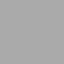

In [5]:
import lavavu

verts = np.reshape(mesh.tri.points, (-1,2))
verts = np.insert(verts, 2, values=mesh.topography.data, axis=1)

# setup viewer
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(verts)
tri1.indices(mesh.tri.simplices)

tri1.values(sp, "stream_power")

tri1.colourmap("drywet")
tri1.colourbar()
lv.window()

In [6]:

import quagmire.equation_systems as systems

## Set up diffusion solver

diffusion_solver = systems.DiffusionEquation(mesh=mesh)
diffusion_solver.neumann_x_mask = fn.misc.levelset(mesh.mask, invert=True)
diffusion_solver.neumann_y_mask = fn.misc.levelset(mesh.mask, invert=True)
diffusion_solver.dirichlet_mask = fn.parameter(0.0)
diffusion_solver.diffusivity = fn.parameter(1.0)
diffusion_solver.verify() # Does nothing but is supposed to check we have everything necessary

# not needed to run
hillslope = diffusion_solver.phi
hillslope.data = mesh.topography.data


## Set up transport solver

transport_solver = systems.ErosionDepositionEquation(mesh=mesh)
transport_solver.rainfall = rainfall_fn
transport_solver.verify()


### Timestepping routine

In [23]:
import lavavu

verts = np.reshape(mesh.tri.points, (-1,2))
verts = np.insert(verts, 2, values=mesh.topography.data, axis=1)

mesh.save_mesh_to_hdf5("mesh.h5")

# setup viewer
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(verts)
tri1.indices(mesh.tri.simplices)

In [24]:
save_fields = False
plot_lavavu = True

efficiency = fn.parameter(1.0)

# reset topography
mesh.verbose = False
with mesh.deform_topography():
    mesh.topography.data = height.copy()
    
h5_filename = "fields_{:06d}.h5"
stats = "Step {:04d} | dt {:.5f} | time {:.4f} | min/mean/max height {:.3f}/{:.3f}/{:.3f} | step walltime {:.3f}"
sim_time = 0.0
steps = 50


for i in range(0, steps):
    t = time()
    
    topography0 = mesh.topography.copy()
    
    # get timestep size
    dt = min(diffusion_solver.diffusion_timestep(), transport_solver.erosion_deposition_timestep())
    
    # build diffusion, erosion + deposition
    diffusion_rate = diffusion_solver.diffusion_rate_fn(mesh.topography).evaluate(mesh)
    erosion_rate, deposition_rate = transport_solver.erosion_deposition_local_equilibrium(efficiency)
    dhdt = diffusion_rate - erosion_rate #+ deposition_rate
    
    # do not rebuilt downhill matrix at half timestep
    mesh.topography.unlock()
    mesh.topography.data = mesh.topography.data + 0.5*dt*dhdt
    mesh.topography.lock()
    
    
    # get timestep size
    dt = min(diffusion_solver.diffusion_timestep(), transport_solver.erosion_deposition_timestep())
    
    # build diffusion, erosion + deposition
    diffusion_rate = diffusion_solver.diffusion_rate_fn(mesh.topography).evaluate(mesh)
    erosion_rate, deposition_rate = transport_solver.erosion_deposition_local_equilibrium(efficiency)
    dhdt = diffusion_rate - erosion_rate #+ deposition_rate
    
    # now take full timestep
    with mesh.deform_topography():
        mesh.topography.data = topography0.data + dt*dhdt
    
    # deal with local minima
#     mesh.low_points_local_patch_fill()
    
    
    # save fields
    if save_fields:
        mesh.save_mesh_to_hdf5(h5_filename.format(i))
        mesh.save_field_to_hdf5(h5_filename.format(i), topo=mesh.topography.data)
        # quagmire.tools.generate_xdmf(h5_filename.format(i))
    
    if plot_lavavu:
        lv.addstep(i)
        verts[:,2] = mesh.topography.data
        tri1.vertices(verts)
        tri1.indices(mesh.tri.simplices)
        tri1.values(erosion_rate, "incision")
        tri1.values(deposition_rate, "deposition")
        tri1.values(diffusion_rate, "diffusion")
    
    
    sim_time += dt
    
    if i/steps*100 in list(range(0,100,10)):
        print(stats.format(i, dt, sim_time, mesh.topography.min(), mesh.topography.data.mean(),
                           mesh.topography.max(), time() - t))

Step 0000 | dt 0.00016 | time 0.0002 | min/mean/max height -0.000/0.174/1.000 | step walltime 6.407
Step 0005 | dt 0.00042 | time 0.0022 | min/mean/max height -0.000/0.174/1.000 | step walltime 5.947
Step 0010 | dt 0.00042 | time 0.0043 | min/mean/max height -0.000/0.174/1.000 | step walltime 3.629
Step 0015 | dt 0.00042 | time 0.0064 | min/mean/max height -0.000/0.174/1.000 | step walltime 3.958
Step 0020 | dt 0.00042 | time 0.0085 | min/mean/max height -0.000/0.174/1.000 | step walltime 5.899
Step 0025 | dt 0.00042 | time 0.0106 | min/mean/max height -0.000/0.174/1.000 | step walltime 7.000
Step 0030 | dt 0.00042 | time 0.0127 | min/mean/max height -0.000/0.174/1.000 | step walltime 8.726
Step 0035 | dt 0.00042 | time 0.0147 | min/mean/max height -0.000/0.174/1.000 | step walltime 14.916
Step 0040 | dt 0.00042 | time 0.0168 | min/mean/max height -0.000/0.174/1.000 | step walltime 3.283
Step 0045 | dt 0.00042 | time 0.0189 | min/mean/max height -0.000/0.174/1.000 | step walltime 5.261

In [25]:
# change in topography

delta_H = mesh.add_variable("dH")
delta_H.unlock()
delta_H.data = mesh.topography.data - height
delta_H.lock()


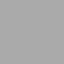

In [26]:
tri1.colourmap("drywet")
tri1.colourbar()
tri1.control.List(options=
                 ["incision", "deposition", "diffusion"], 
                  property="colourby", value="kappa", command="redraw")

# There are issues with lavavu here
lv.control.TimeStepper()
lv.window()

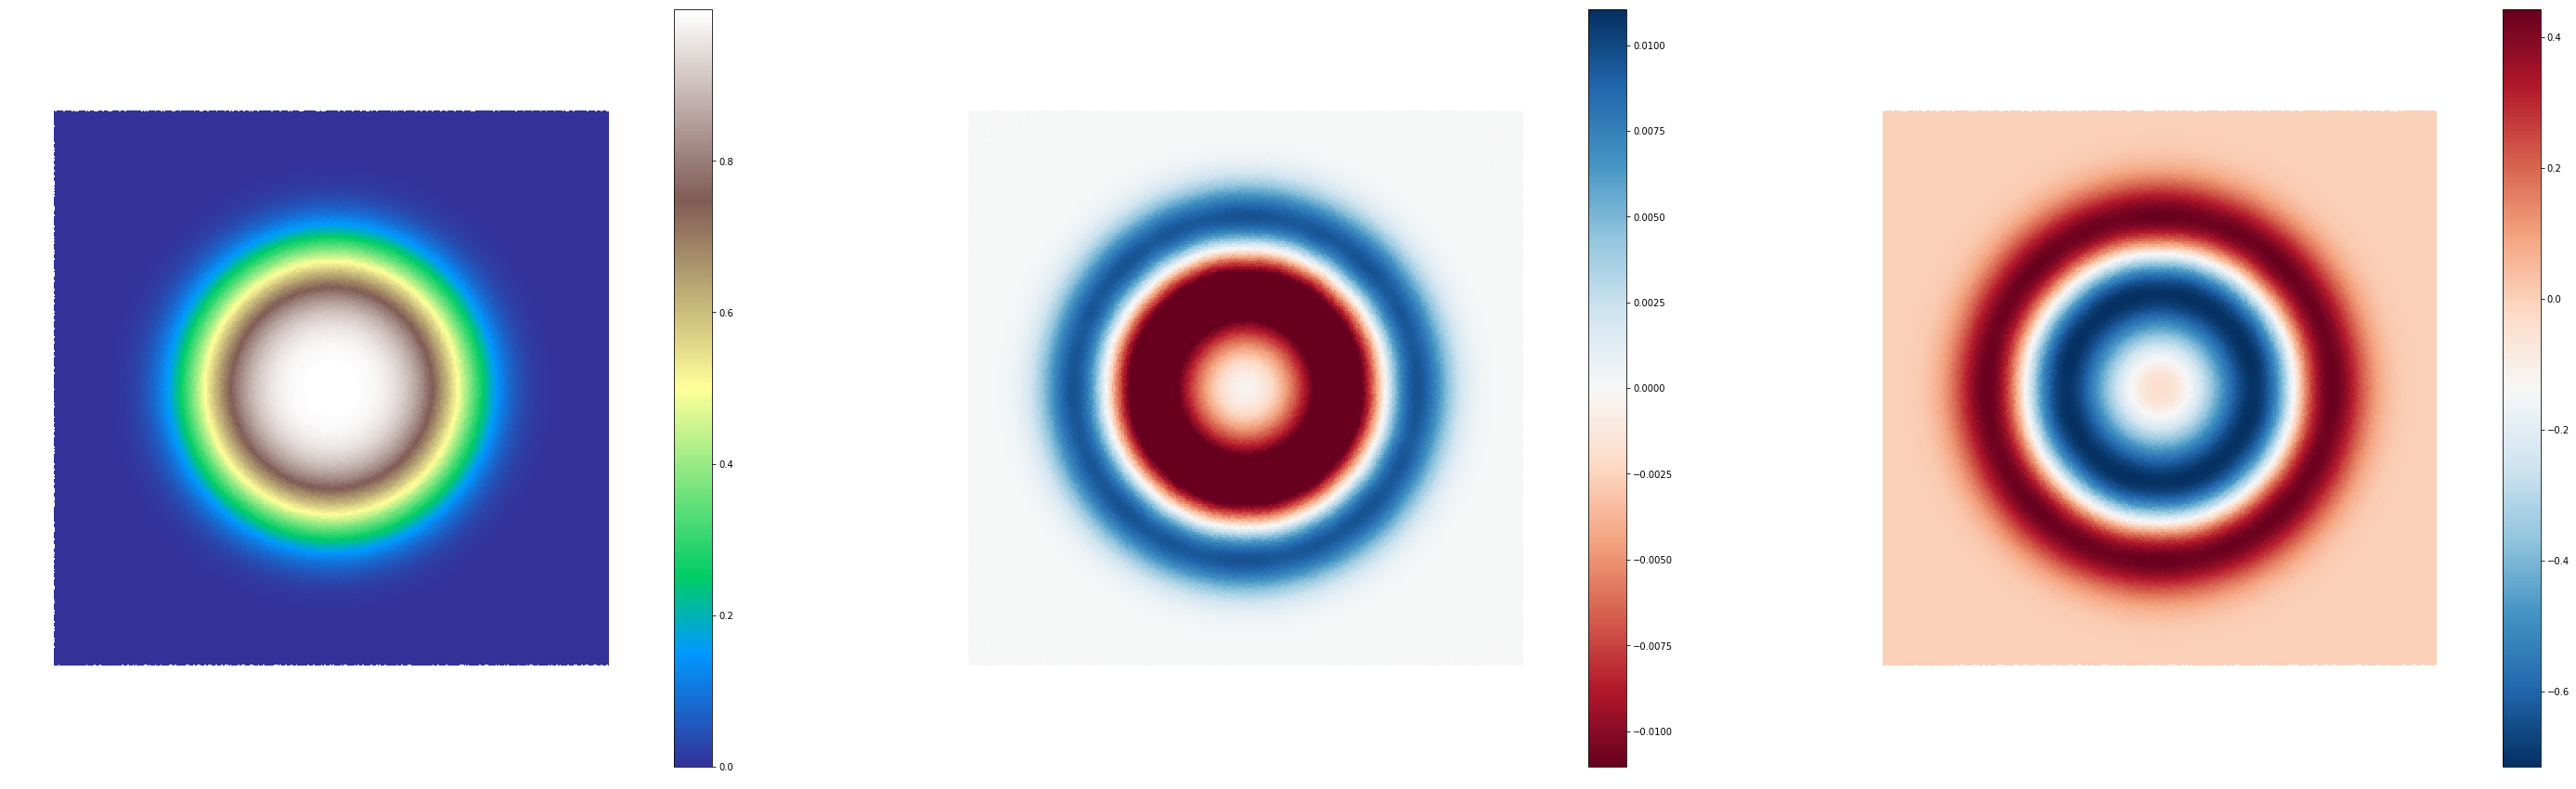

In [22]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(50,15))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')


dhmax = np.abs(delta_H.data).mean() * 3.0
# ermax = np.abs(incision_rate.data).mean() * 3.0
# depmax = np.abs(dhdt_fn.evaluate(mesh)).mean() * 3.0
    
#im1 = ax1.tripcolor(x, y, sp.tri.simplices, delta, cmap=plt.cm.RdBu, vmin=-dhmax, vmax=dhmax)    
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, mesh.topography.data, cmap=plt.cm.terrain)
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, delta_H.data, cmap='RdBu', vmin=-dhmax, vmax=dhmax)
im3 = ax3.tripcolor(x, y, mesh.tri.simplices, dhdt, cmap='RdBu_r',)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()
